# Retrospective Timing

In [1]:
import nengo
import nengo_spa as spa
import nengolib
import nengo_extras
import pytry
import numpy as np
import pylab
import pandas as pd
import seaborn as sns
import itertools
import scipy
import string
from scipy.ndimage import gaussian_filter1d
from sklearn.decomposition import PCA
from nengo_extras.plot_spikes import (
    cluster, merge, plot_spikes, preprocess_spikes, sample_by_variance)
from nengo.utils.ensemble import response_curves, tuning_curves

import os
import sys

%pylab inline
import pylab
import cycler
import matplotlib.collections as mcol

%run ../dashedlines.py
%run ../UTC.py

Populating the interactive namespace from numpy and matplotlib


/Users/Joost/opt/anaconda3/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['pylab']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
plt.rcParams['font.size'] = 14
plt.rcParams['figure.titlesize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False



## The effect of number of stimuli on retrospective time estimates

In [3]:
# Set parameters
D = 64
dim_list = np.arange(1, 7)
N_list = np.arange(1, 11)

get_dat_method = 'load'

In [4]:
%%capture

if get_dat_method == 'simulate':
    for N, dim in itertools.product(N_list, dim_list):
        UTC().run(dimensions=dim,
                         D=D,
                         full_output=True,
                         direct_mode=True,
                         gain_i=1.,
                         n_inputs=N,
                         task_type = 'retrospective',
                         data_dir='retrospective_timing_nstim',
                         trial_duration=1.5,
                         effective_theta=1.,
                         stimulus_function=[],
                         ID=N)



In [5]:
retrospective_data = pytry.read('retrospective_timing_nstim')

In [6]:
retrospective_dt = pd.DataFrame(retrospective_data)

In [7]:
# Reconstruct vocabulary object
vocab = spa.Vocabulary(D)
conditions = (retrospective_dt['ID']==10)

for i in range(0, len(retrospective_dt[conditions]['sp_keys'].values[0])):
    vocab.add(retrospective_dt[conditions]['sp_keys'].values[0][i], 
              retrospective_dt[conditions]['sp_vectors'].values[0][i])


In [8]:
# read in data
retro_state_input = []
retro_state = []
for dim, N in itertools.product(dim_list, N_list):
    conditions = (retrospective_dt['ID']==N) & (retrospective_dt['dimensions']==dim)
    retro_state_input.append(retrospective_dt[conditions]['state'].values[0])
    retro_state.append(retrospective_dt[conditions]['x'].values[0])
    

In [9]:
#fig, ax = plt.subplots(len(N_list), 1, figsize=(5, 3*len(N_list)))

cc = []
cc_abs = []
#cc2 = []

colors = plt.cm.Blues(np.linspace(0.4, 1, len(N_list)))
sp_list = list(vocab.keys())

for i in range(0, len(N_list)*len(dim_list)):
    temp_cc = []
    temp_cc_abs = []
    for sp in sp_list:
        # readout temporal window
        temp, y = readout_window(np.moveaxis(retro_state[i], 1, 0), D, 1200, 
                              np.shape(retro_state[i])[2], vocab[sp].v)
        #ax[i].plot(temp)
        # take sum over time
        temp_cc.append(np.sum(temp))
        temp_cc_abs.append(np.sum(abs(temp)))
                
    #ax[i].set_ylim([-0.3, 1.3])
        
    cc.append(np.sum(np.asarray(temp_cc)))
    cc_abs.append(np.sum(temp_cc_abs))

/Users/Joost/opt/anaconda3/lib/python3.9/site-packages/scipy/signal/_filter_design.py:1746: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "


In [10]:
contextual_change = np.asarray(cc)
contextual_change = contextual_change.reshape(6, 10)

contextual_change_abs = np.asarray(cc_abs)
contextual_change_abs = contextual_change_abs.reshape(6, 10)

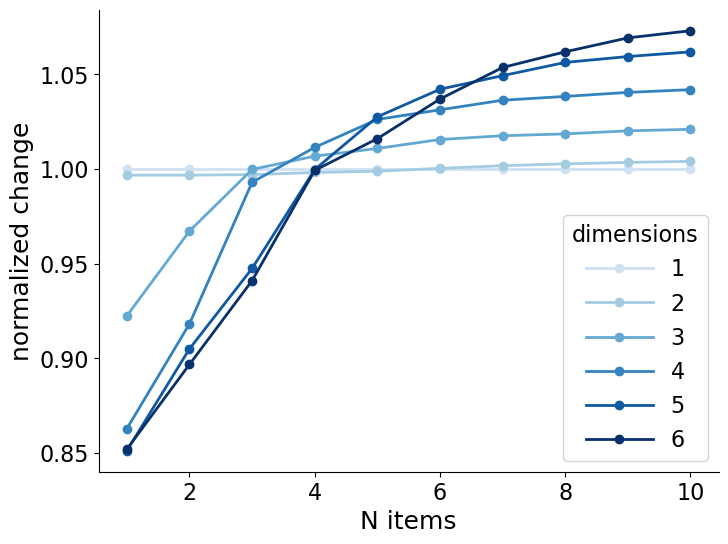

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
colors = plt.cm.Blues(np.linspace(0.2, 1, len(dim_list)))

for i in range(0, len(dim_list)):
    ax.plot(np.arange(1, len(N_list)+1), 
            contextual_change_abs[i,:]/np.mean(contextual_change_abs[i,:]), 
             marker='o', color=colors[i], lw=2, label=dim_list[i])

ax.legend(title='dimensions', title_fontsize=16, handlelength=3, fontsize=16)
ax.set_xlabel('N items', size=18)
ax.set_ylabel('normalized change', size=18)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(axis='both', which='major', labelsize=16)

fig.savefig('N_stim.png', dpi=400)

## The effect of cognitive load on prospective and retrospective timing

In [12]:
# Set parameters
D = 64
dim = 6


def stimulus_function(t):
    if t > 0 and t < 0.25:
        return 'A'
    elif t > 0.25 and t < 0.5:
        return 'B'
    elif t > 0.5 and t < 0.75:
        return 'C'
    elif t > 0.75 and t < 1.:
        return 'D'
    else:
        return 0
    
gi_list = np.arange(0, 2.25, 0.25)

In [13]:
%%capture

for gi in gi_list:
    UTC().run(dimensions=dim,
                     D=D,
                     full_output=True,
                     direct_mode=False,
                     gain_i=gi,
                     task_type = 'prospective_sensory',
                     stimulus_function=stimulus_function,
                     data_dir='pro_retro',
                     trial_duration=1.5)

In [ ]:
%%capture

for gi in gi_list:
    UTC().run(dimensions=dim,
                     D=D,
                     full_output=True,
                     direct_mode=False,
                     gain_i=gi,
                     task_type = 'retrospective',
                     stimulus_function=stimulus_function,
                     data_dir='pro_retro',
                     trial_duration=1.5)

In [ ]:
pro_retro_data = pytry.read('pro_retro')

In [ ]:
pro_retro_dt = pd.DataFrame(pro_retro_data)

In [ ]:
# Reconstruct vocabulary object
vocab = spa.Vocabulary(int(pro_retro_dt['D'][0]))
for i in range(0, len(pro_retro_dt['sp_keys'][0])):
    vocab.add(pro_retro_dt['sp_keys'][0][i], pro_retro_dt['sp_vectors'][0][i])

In [ ]:
# read in data
pro_state_input = []
pro_state = []
for i in range(len(gi_list)):
    conditions = (pro_retro_dt['task_type']=='prospective_sensory') & (pro_retro_dt['gain_i']==gi_list[i])
    pro_state_input.append(pro_retro_dt[conditions]['state'].values[0])
    pro_state.append(pro_retro_dt[conditions]['x'].values[0])
    
    
retro_state_input = []
retro_state = []
for i in range(len(gi_list)):
    conditions = (pro_retro_dt['task_type']=='retrospective') & (pro_retro_dt['gain_i']==gi_list[i])
    retro_state_input.append(pro_retro_dt[conditions]['state'].values[0])
    retro_state.append(pro_retro_dt[conditions]['x'].values[0])


In [ ]:
prospective_estimates = []
stim_decoding = []
contextual_change = []

sp_list = ['A', 'B', 'C', 'D']

trange = np.linspace(-1, 0, 1000)
for i in range(len(gi_list)):
    # prospective estimate
    temp, y = readout_window(np.moveaxis(pro_state[i], 1, 0), D, 1050, dim, vocab['T'].v)
    plt.plot(temp)
    prospective_estimates.append(np.mean(abs(temp)))
    
    temp_dec = [] # maximal stimulus decoding estimate
    temp_ch = [] # retrospective estimate
    for sp in sp_list:
        temp, y = readout_window(np.moveaxis(pro_state[i], 1, 0), D, 1050, dim, vocab[sp].v)
        
        temp_ch.append(np.mean(abs(temp)))
        
        if sp == 'A':
            stim_temp, y = readout_window(np.moveaxis(pro_state[i], 1, 0), D, 1000, dim, vocab[sp].v)
            temp_dec = np.max(stim_temp)
        
    stim_decoding.append(temp_dec)
    contextual_change.append(np.sum(np.asarray(temp_ch)))
    

prospective_estimates = np.asarray(prospective_estimates)  
stim_decoding = np.asarray(stim_decoding)  
contextual_change = np.asarray(contextual_change)



In [ ]:
plt.rcParams['font.size'] = 18
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False



In [ ]:
# Block et al. (2010) data
block_2010_prospective = np.array([0.9217228464419477, 0.7985018726591762])
block_2010_retrospective = np.array([0.8475655430711612, 0.9235955056179777])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,6), sharey=True, sharex=False)

ax1.set_title('Block et al. (2010)')
ax1.plot([0, 1.5], block_2010_prospective, 'ko-', label='prospective')

ax1.plot([0, 1.5], block_2010_retrospective, 'wo-', label='retrospective',
        color='black', ls='dashed', mec='black', mfc='white')

#ax1.set_ylim([0.70, 1.10])
ax1.set_xlim([-0.5, 2.])

ax1.set_xticks([0, 1.5])
ax1.set_xticklabels(['low', 'high'])
ax1.set_xlabel('Cognitive Load')
ax1.set_ylabel('Duration judgement ratio')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.legend(loc='upper center')

# Model 
ax2.set_title('UTC model')
ax2.plot(gi_list, prospective_estimates, 'ko-', label='prospective')

ax2.plot(gi_list, contextual_change*0.05+0.85, 'wo-', label='retrospective',
        color='black', ls='dashed', mec='black', mfc='white')

ax2.set_ylim([0.70, 1.10])
ax2.set_xlim([-0.4, 2.4])
ax2.set_xticks([0, 0.5, 1., 1.5, 2.])
ax2.set_xlabel('Attention to stimuli $(g_s)$')
ax2.set_ylabel('')
ax2.set_yticks(np.arange(0.7, 1.1, 0.05))
ax2.set_yticklabels(['0.70', '', '0.80', '', '0.90', '', '1.00', '', '1.10'])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

fig.tight_layout()

fig.savefig('block2010_modelfit.png', dpi=400)
#fig.savefig('block2010_modelfit.tiff', dpi=400, bbox_inches='tight')